In [35]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torch.utils.tensorboard import SummaryWriter


In [17]:
from graphviz import Digraph
from torchviz import make_dot
from IPython.display import Image, display

In [21]:
import os
import glob
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [142]:
def load_csv_files(root_path, eye):
    datas_info = []
    datas = []
    labels = []

    # Iterate over all dataset subfolders
    for dataset_folder in glob.glob(os.path.join(root_path, '*_PATH')):
        dataset_name = os.path.basename(dataset_folder)
        
        # Iterate over the FV and TASK subfolders
        for label_folder in ['FV', 'TASK']:
            subfolder_path = os.path.join(dataset_folder, f'{dataset_name}_{label_folder}')
            
            if not os.path.exists(subfolder_path):
                continue
            
            # Load each CSV file in the current FV or TASK folder
            for csv_file in glob.glob(os.path.join(subfolder_path, eye, '*.csv')):

                parts = dataset_name.split("_")  # Split the folder name by "_"
                dataset = parts[0]
                video = parts[1]
                datas_info.append(f"{dataset}_{video}")

                df = pd.read_csv(csv_file, header=0)
                #print("Available columns:", df.columns)
                datas.append(df)
                
                # Label data based on the folder (0 for FV, 1 for TASK)
                label = 0 if label_folder == 'FV' else 1
                labels.append(label)


    return list(zip(datas_info, datas, labels))


In [143]:
# Load the data
root_path = '../PATH'  # Replace with your root path
eye = "Dominant"
selected_columns = ['Start X', 'Start Y', 'End X','End Y', 'Duration ms']

zipped_data = load_csv_files(root_path, eye)
                

In [152]:
print(zipped_data[0][1].columns)

Index(['Type', 'Start time ms', 'End time ms', 'Start X', 'Start Y', 'End X',
       'End Y', 'Duration ms', 'Amplitude deg', 'Direction deg'],
      dtype='object')


In [204]:
def process_sequences(data, labels, max_length):
    processed_data = []
    processed_labels = []
    
    for i, seq in enumerate(data):
        seq = torch.tensor(seq.iloc[:, :].values)
        seq_length = seq.shape[0]
        label = labels[i]
        
        # If the sequence is longer than max_length, split it into chunks
        if seq_length > max_length:
            num_splits = seq_length // max_length
            remainder = seq_length % max_length
            
            # Split the sequence into full segments of max_length
            for j in range(num_splits):
                segment = seq[j * max_length:(j + 1) * max_length]
                processed_data.append(segment)
                processed_labels.append(label)
            
            # Add the remainder part as a new sequence if it exists
            if remainder > 50:
                remainder_segment = seq[num_splits * max_length:]
                processed_data.append(remainder_segment)
                processed_labels.append(label)
        
        # If the sequence length is less than or equal to max_length, pad it
        else:
            processed_data.append(seq)
            processed_labels.append(label)
    
    # Pad all sequences to the max_length
    padded_data = []
    for seq in processed_data:
        print("seq shape is : ", seq.shape)
        padding_needed = max_length - seq.shape[0]
        if padding_needed > 0:
            repeat_count = (max_length // seq.shape[0]) + 1
            repeated_data = seq.repeat(repeat_count, 1)
            reflected_part = repeated_data[-(padding_needed):].flip(dims=(0,))
            padded_seq = torch.cat([seq, reflected_part], dim=0)
            #seq_mirrored = seq[::-1, :]
            # Pad sequence to the right with zeros to reach max_length
            #padded_seq = torch.cat([seq, seq_mirrored[:padding_needed, :]], dim=0)
            #padded_seq = F.pad(seq, (0, padding_needed, 0, 0), mode = "reflect")
            print("padded shape is : ", padded_seq.shape)
            padded_data.append(padded_seq)
        else:
            padded_data.append(seq)
    
    # Convert to tensor
    padded_data = torch.stack(padded_data)
    processed_labels = torch.tensor(processed_labels, dtype=torch.float32)
    
    return padded_data, processed_labels

In [205]:
selected_columns = ['Start X', 'Start Y', 'End X', 'End Y', 'Duration ms']
data = [seq[1] for seq in zipped_data]
data = [d[selected_columns] for d in data]
#print(data[0])
label = [seq[2] for  seq in zipped_data]
max_seq_length = max([len(seq) for seq in data])
print("max length is ", max_seq_length)

padded_data, processed_labels = process_sequences(data, label, max_length=100)
# Split the processed data into train and test sets
train_features, test_features, train_labels, test_labels = train_test_split(
    padded_data, processed_labels, test_size=0.2, random_state=42
)

print(f'Train data shape: {len(train_features)}')
print(f'Test data shape: {len(test_features)}')

batch_size = 32       # Batch size for training
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

max length is  867
seq shape is :  torch.Size([83, 5])
padded shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([71, 5])
padded shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([71, 5])
padded shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([85, 5])
padded shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([97, 5])
padded shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([83, 5])
padded shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([93, 5])
padded shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([100, 5])
seq shape is :  torch.Size([95, 5])
padded

In [206]:
# Assuming you have defined your train_loader already
# Get a single batch from the train_loader
for inputs, labels in train_loader:
    print("Input Batch Shape:", inputs.shape)
    print("Labels Batch Shape:", labels.shape)
    
    # Optionally, print a few samples from the batch
    print("Inputs:", inputs)
    print("Labels:", labels)
    break  # Stop after printing the first batch


Input Batch Shape: torch.Size([32, 100, 5])
Labels Batch Shape: torch.Size([32])
Inputs: tensor([[[ 4.6751e+02,  1.3664e+02,  4.6751e+02,  1.3664e+02,  2.0500e+02],
         [ 4.6751e+02,  1.3664e+02,  3.8221e+02,  1.0377e+02,  2.0000e+00],
         [ 3.8221e+02,  1.0377e+02,  3.8221e+02,  1.0377e+02,  1.6400e+02],
         ...,
         [ 1.9644e+02,  3.1178e+02,  4.6262e+02,  1.7692e+02,  1.5000e+01],
         [ 4.6262e+02,  1.7692e+02,  4.6262e+02,  1.7692e+02,  7.3100e+02],
         [ 4.6262e+02,  1.7692e+02,  4.2064e+02,  1.0907e+02,  1.0000e+00]],

        [[-8.3780e+00,  3.6959e+02, -8.3780e+00,  3.6959e+02,  1.0800e+02],
         [-8.3780e+00,  3.6959e+02,  4.2009e+02,  4.4085e+02,  2.9000e+01],
         [ 4.2009e+02,  4.4085e+02,  4.2009e+02,  4.4085e+02,  2.1700e+02],
         ...,
         [ 3.2968e+01,  4.6938e+02,  3.2968e+01,  4.6938e+02,  9.3200e+02],
         [ 9.5561e+01,  4.7916e+02,  3.2968e+01,  4.6938e+02,  1.0000e+00],
         [ 9.5561e+01,  4.7916e+02,  9.5561e+

max_length is 200
mean_length is 200.0


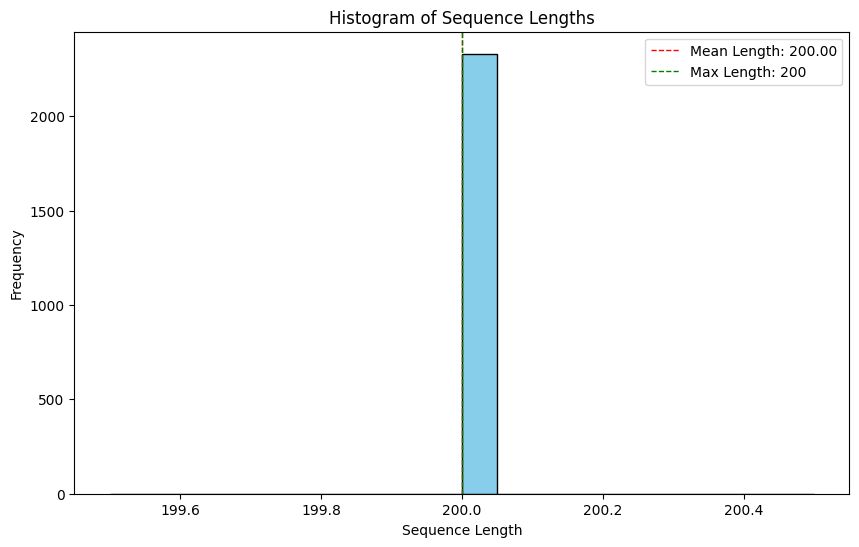

max_length is 867
mean_length is 156.0062015503876


In [46]:
sequence_lengths = [seq.shape[0] for seq in train_data]

# Find max and mean lengths
max_length = max(sequence_lengths)
mean_length = np.mean(sequence_lengths)

# Print the max and mean length
print("max_length is", max_length)
print("mean_length is", mean_length)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'Mean Length: {mean_length:.2f}')
plt.axvline(max_length, color='green', linestyle='dashed', linewidth=1, label=f'Max Length: {max_length}')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths')
plt.legend()
plt.show()# Find the maximum sequence length
max_length = max([seq.shape[0] for seq in data])
mean_length = np.mean([seq.shape[0] for seq in data])

print("max_length is " + str(max_length))
print("mean_length is " + str(mean_length))

In [132]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ",device)

device is  cuda


LSTM

In [207]:
sequence_length = 100  # Number of timesteps per sequence
feature_count = 5     # Number of features (excluding label)
hidden_size = 32      # LSTM hidden layer size
num_layers = 1        # Number of LSTM layers
learning_rate = 0.00001
num_epochs = 100

In [208]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for binary classification

    def forward(self, x):
        # x shape: (batch_size, sequence_length, feature_count)
        lstm_out, _ = self.lstm(x)
        # Use the last time step's output for classification
        output = self.fc(lstm_out[:, -1, :])
        return output

In [209]:

# Create an instance of the model and move it to the appropriate device
model = LSTMModel(feature_count, hidden_size, num_layers).to(device)
criterion = nn.BCEWithLogitsLoss() 
# Ensure your optimizer is also using the model parameters on the correct device
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# Initialize the model


Model graph has been saved as 'lstm_model.png'


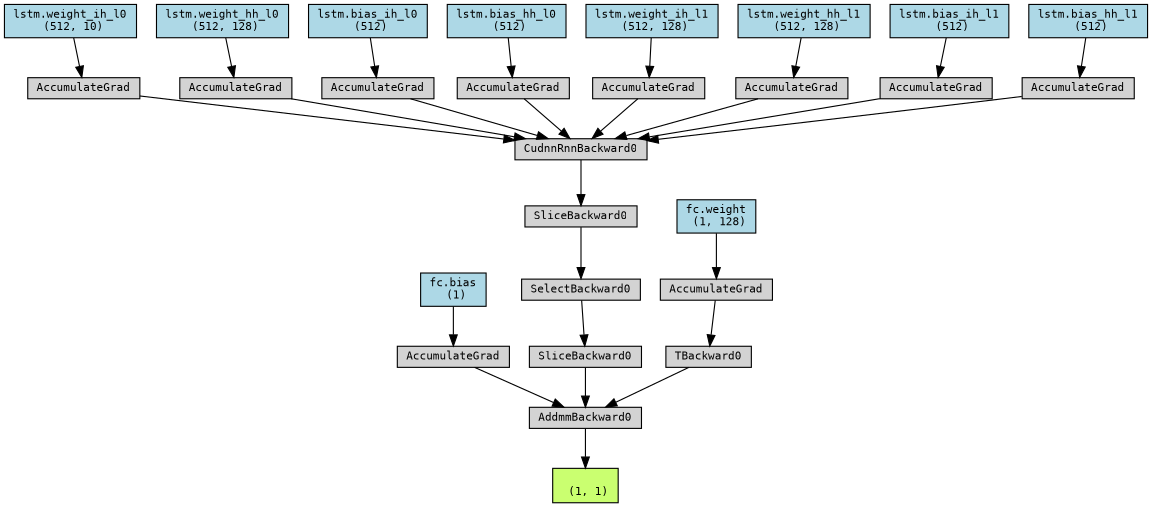

In [70]:
# Create a dummy input tensor with batch size of 1 and sequence length of 10
x = torch.randn(1, 10, feature_count).to(device)

# Forward pass through the model to get the output
output = model(x)

# Generate and visualize the computation graph
dot = make_dot(output, params=dict(list(model.named_parameters())))
dot.format = 'png'  # Set output format as PNG
dot.render('lstm_model')  # Saves the graph as 'lstm_model.png'

print("Model graph has been saved as 'lstm_model.png'")
display(Image(filename='lstm_model.png'))

In [73]:
def get_log_dir(base_dir='runs/train'):
    i = 0
    while True:
        log_dir = f"{base_dir}{i}"  # Create the directory name
        if not os.path.exists(log_dir):  # Check if the directory exists
            os.makedirs(log_dir)  # Create the directory if it doesn't exist
            return log_dir  # Return the new log directory
        i += 1  # Increment the index

In [211]:
# Get a unique log directory
log_dir = get_log_dir()
# Initialize the SummaryWriter with the unique log directory
writer = SummaryWriter(log_dir=log_dir)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_start_time = time.time()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Move inputs and labels to the same device as the model
        inputs = inputs.float()
        inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True).to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)  # Squeeze labels to match output shape
        
        loss.backward()  # Backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
        optimizer.step()  # Update weights

        # Record loss
        total_loss += loss.item()

        # Calculate accuracy
        predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()  # Binary classification
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    # Log the loss and accuracy to TensorBoard
    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)

    epoch_end_time = time.time()  # Record the end time of the epoch
    epoch_duration = epoch_end_time - epoch_start_time  # Calculate the duration of the epoch

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Time: {epoch_duration:.2f} seconds')   
writer.close()

Epoch [1/100], Loss: nan, Time: 0.24 seconds
Epoch [2/100], Loss: nan, Time: 0.22 seconds
Epoch [3/100], Loss: nan, Time: 0.20 seconds
Epoch [4/100], Loss: nan, Time: 0.21 seconds
Epoch [5/100], Loss: nan, Time: 0.23 seconds
Epoch [6/100], Loss: nan, Time: 0.21 seconds
Epoch [7/100], Loss: nan, Time: 0.20 seconds
Epoch [8/100], Loss: nan, Time: 0.22 seconds
Epoch [9/100], Loss: nan, Time: 0.20 seconds
Epoch [10/100], Loss: nan, Time: 0.22 seconds
Epoch [11/100], Loss: nan, Time: 0.23 seconds
Epoch [12/100], Loss: nan, Time: 0.23 seconds
Epoch [13/100], Loss: nan, Time: 0.24 seconds
Epoch [14/100], Loss: nan, Time: 0.24 seconds
Epoch [15/100], Loss: nan, Time: 0.24 seconds
Epoch [16/100], Loss: nan, Time: 0.26 seconds
Epoch [17/100], Loss: nan, Time: 0.27 seconds


KeyboardInterrupt: 

In [47]:
%load_ext tensorboard
%tensorboard --logdir=runs/test

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 42707), started 0:06:59 ago. (Use '!kill 42707' to kill it.)

In [31]:
# Testing the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True)
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs))  # Get binary predictions
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 48.26%


Transformer

In [136]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Input embedding layer (for potential extra embeddings or directly use the input size)
        self.input_fc = nn.Linear(input_size, hidden_size)

        # Define Transformer encoder layers with batch_first=True
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer, num_layers=num_layers
        )

        # Output layer for binary classification
        self.fc = nn.Linear(hidden_size, 1)  # Sigmoid activation will be applied later
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length, feature_size)
        x = self.input_fc(x)  # Apply input projection to hidden size

        # Pass the input through the transformer encoder
        transformer_out = self.transformer_encoder(x)

        # We will take the output of the last token in the sequence for classification
        last_token_output = transformer_out[:, -1, :]  # (batch_size, hidden_size)

        # Pass through fully connected layer for classification
        output = self.fc(last_token_output)  # (batch_size, 1)

        return output  # (batch_size, 1)


# Define model hyperparameters
input_size = 5  # Number of features (like in your data: 5 features)
hidden_size = 64  # Hidden layer size in the Transformer
num_heads = 4  # Number of attention heads
num_layers = 2  # Number of Transformer encoder layers

# Initialize the model
model = TransformerModel(input_size=input_size, hidden_size=hidden_size, num_heads=num_heads, num_layers=num_layers).to(device)
# Define loss function (BCE with logits for binary classification)
criterion = nn.BCEWithLogitsLoss()
# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [137]:
epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # inputs shape: (batch_size, sequence_length, feature_size)
        # labels shape: (batch_size,)
        
        # Send inputs and labels to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(inputs)  # (batch_size, 1) for binary classification

        # Compute the loss
        loss = criterion(output.squeeze(), labels.float())  # Squeeze to remove extra dimension from output
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")# Example training loop



Epoch [1/100], Loss: nan


KeyboardInterrupt: 

In [ ]:
# Model evaluation
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()  # Apply threshold
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')


In [ ]:
# Inference / Prediction
def predict(model, inputs):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()  # Apply threshold to get binary class
    return predicted

# Example usage for prediction
inputs = torch.tensor(..., dtype=torch.float32)  # Your input tensor (e.g., of shape [batch_size, seq_len, features])
predictions = predict(model, inputs)
